In [3]:
import os

from climada.util.api_client import Client
from climada.util.config import CONFIG
from climada.util import coordinates
from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard
from climada.entity.impact_funcs.impact_func_set import ImpactFuncSet

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import ee
import geemap

import rioxarray as rxr
import xarray as xr
import rioxarray
import os
import re
import glob
import pandas as pd

# INICIALIZE

## GEE

In [5]:
ee.Authenticate()
ee.Initialize()

## CLIMADA

In [6]:
client = Client()

# DATASETS

##  FLOOD HAZARD

In [7]:
# Colección de inundación fluvial
inunriver = ee.ImageCollection("WRI/Aqueduct_Flood_Hazard_Maps/V2")

# Región de interés: Colombia
colombia = ee.FeatureCollection("FAO/GAUL/2015/level0") \
              .filter(ee.Filter.eq("ADM0_NAME", "Colombia"))

# Consulta: escenario rcp8p5, inundación fluvial (inunriver), periodo 100 años, año 2030
flood_img = (inunriver
             .filter(ee.Filter.eq("climatescenario", "rcp8p5"))
             .filter(ee.Filter.eq("floodtype", "inunriver"))
             .filter(ee.Filter.eq("returnperiod", 100))
             .filter(ee.Filter.eq("year", 2030))   # <- aquí es "year", no "año"
             .first())

# Visualización
Map = geemap.Map()
Map.centerObject(colombia, 6)
Map.addLayer(flood_img.clip(colombia).select("inundation_depth"),
             {"min": 0, "max": 5, "palette": ["white", "red", "darkblue"]},
             "Inundación fluvial rcp8.5 - 2030 (100 años)")
Map

Map(center=[3.8953556727233427, -73.0789456023007], controls=(WidgetControl(options=['position', 'transparent_…

In [8]:
# Tu región de interés
colombia = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq("ADM0_NAME", "Colombia"))

# Definir escenarios climáticos
climate_scenarios = {
    "historical": "flood_historical_",  # Ajusta según el nombre real de las bandas en tu dataset
    "rcp4p5": "flood_rcp4p5_",
    "rcp8p5": "flood_rcp8p5_"
}

# Períodos de retorno
return_periods = [1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]

# Crear carpeta de salida
out_dir = "./Data/Floods"
os.makedirs(out_dir, exist_ok=True)

# Parámetros
scenarios = ["historical", "rcp4p5", "rcp8p5"]
return_periods = [1, 2, 5, 10, 25, 50, 100, 250, 500, 1000]

# Geometría de Colombia (ajústalo a tu FeatureCollection si ya lo tienes cargado)
colombia = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(
    ee.Filter.eq("ADM0_NAME", "Colombia")
)

# Recorremos escenarios y periodos
for sc in scenarios:
    for rp in return_periods:
        try:
            # Nombre de archivo
            out_tif = os.path.join(out_dir, f"{sc}_rp{rp}.tif")

            print(f"Exportando: {out_tif}")

            # Dataset de inundaciones de WRI Aqueduct
            flood_img = (ee.ImageCollection("WRI/Aqueduct_Flood_Hazard_Maps/V2")
             .filter(ee.Filter.eq("climatescenario", sc))   # ejemplo: "rcp8p5"
             .filter(ee.Filter.eq("floodtype", "inunriver")) # o "coastal"
             .filter(ee.Filter.eq("returnperiod", rp))       # ejemplo: 100
             .first())

            # Validación de imagen
            if flood_img is None:
                print(f"No se encontró imagen para {sc} - rp{rp}")
                continue

            # Exportación corregida (sin 'image=')
            geemap.ee_export_image(
                flood_img.clip(colombia).select("inundation_depth"),
                filename=out_tif,
                scale=1000,
                region=colombia.geometry(),
                crs="EPSG:4326"
            )

        except Exception as e:
            print(f"Error exportando {sc} - rp{rp}: {e}")

Exportando: ./Data/Floods\historical_rp1.tif
Generating URL ...
An error occurred while downloading.
Image.clip: Parameter 'input' is required and may not be null.
Exportando: ./Data/Floods\historical_rp2.tif
Generating URL ...
Please wait ...
Data downloaded to d:\Doctorado\Beca Doctorado\Beca 2025\CLIMADA\Data\Floods\historical_rp2.tif
Exportando: ./Data/Floods\historical_rp5.tif
Generating URL ...
Please wait ...
Data downloaded to d:\Doctorado\Beca Doctorado\Beca 2025\CLIMADA\Data\Floods\historical_rp5.tif
Exportando: ./Data/Floods\historical_rp10.tif
Generating URL ...
Please wait ...
Data downloaded to d:\Doctorado\Beca Doctorado\Beca 2025\CLIMADA\Data\Floods\historical_rp10.tif
Exportando: ./Data/Floods\historical_rp25.tif
Generating URL ...
Please wait ...
Data downloaded to d:\Doctorado\Beca Doctorado\Beca 2025\CLIMADA\Data\Floods\historical_rp25.tif
Exportando: ./Data/Floods\historical_rp50.tif
Generating URL ...
Please wait ...
Data downloaded to d:\Doctorado\Beca Doctorado\

In [9]:
# Carpeta con los GeoTIFFs
data_dir = "./Data/Floods"

# Buscar archivos tif
tif_files = [f for f in os.listdir(data_dir) if f.endswith(".tif")]

data_list = []

for f in tif_files:
    # Extraer scenario y returnperiod del nombre del archivo
    match = re.match(r"(historical|rcp4p5|rcp8p5)_rp(\d+)\.tif", f)
    if not match:
        continue
    scenario, rp = match.groups()
    rp = int(rp)

    # Abrir raster con rioxarray
    da = rioxarray.open_rasterio(os.path.join(data_dir, f))

    # Usualmente rioxarray abre con dimensión "band"
    da = da.squeeze("band", drop=True)

    # Añadir atributos
    da = da.assign_coords(
        climatescenario=scenario,
        returnperiod=rp
    )

    data_list.append(da)

# Combinar todos en un Dataset
ds = xr.concat(data_list, dim="layer")

# Reorganizar con dims más claros
ds = ds.set_index(layer=["climatescenario", "returnperiod"])
ds = ds.unstack("layer")

# Convertir DataArray -> Dataset
ds = ds.to_dataset(name="flood")

In [10]:
ds

<xarray.Dataset> Size: 354MB
Dimensions:          (climatescenario: 3, returnperiod: 9, x: 1670, y: 1963)
Coordinates:
  * climatescenario  (climatescenario) <U10 120B 'historical' 'rcp4p5' 'rcp8p5'
  * returnperiod     (returnperiod) int32 36B 2 5 10 25 50 100 250 500 1000
  * x                (x) float64 13kB -81.86 -81.85 -81.84 ... -66.88 -66.87
  * y                (y) float64 16kB 13.4 13.39 13.38 ... -4.209 -4.218 -4.227
    spatial_ref      int32 4B 0
Data variables:
    flood            (y, x, climatescenario, returnperiod) float32 354MB -9.9...

In [6]:
# 1. Ruta donde guardaste los GeoTIFFs de WorldPop
path = "./Data/Pop"
files = sorted(glob.glob(f"{path}/*.tif"))

# 2. Crear lista de años (2015–2030)
years = list(range(2015, 2031))

# 3. Leer y apilar en un xarray.Dataset
arrays = []
for file, year in zip(files, years):
    da = rxr.open_rasterio(file, masked=True).squeeze()  # quita la dim "band"
    da = da.assign_coords(time=pd.to_datetime(f"{year}-01-01"))  # coordenada temporal
    arrays.append(da)

# 4. Concatenar en un solo DataArray
da_pop = xr.concat(arrays, dim="time")

# 5. Guardar en Dataset (opcional)
ds_pop = xr.Dataset({"population": da_pop})

ds_pop

<xarray.Dataset> Size: 275MB
Dimensions:      (x: 1787, y: 2403, time: 16)
Coordinates:
    band         int32 4B 1
  * x            (x) float64 14kB -81.74 -81.73 -81.72 ... -66.87 -66.86 -66.85
  * y            (y) float64 19kB 15.8 15.79 15.78 ... -4.204 -4.212 -4.221
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 128B 2015-01-01 2016-01-01 ... 2030-01-01
Data variables:
    population   (time, y, x) float32 275MB nan nan nan nan ... nan nan nan nan

# RESULTS

## CLIMADA FRAMEWORK FLOODS

In [2]:
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
from climada.engine import ImpactCalc
import numpy as np
from scipy.sparse import csr_matrix
from climada.hazard import Hazard, Centroids
import matplotlib.pyplot as plt
import rioxarray as rxr

In [3]:
# -------------------------------
# Función auxiliar para leer un solo tif y devolver hazard
# -------------------------------
def tif_to_hazard(tif_path, haz_type="RF", scenario="historical"):
    # 1. Abrir raster
    da = rxr.open_rasterio(tif_path).squeeze()
    arr = da.values
    arr = np.where(arr < 0, 0, arr)  # reemplazar nodata negativos por 0
    
    # 2. Coordenadas
    lat = da["y"].values
    lon = da["x"].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    centroids = Centroids(lat=lat_grid.flatten(), lon=lon_grid.flatten())
    
    # 3. Extraer periodo de retorno del nombre del archivo (ej. rp50 → 50)
    fname = tif_path.split("/")[-1]
    rp = int("".join([c for c in fname if c.isdigit()]))  # extrae 10, 50, 100...
    freq = 1 / rp
    
    # 4. Crear objeto Hazard
    haz = Hazard(haz_type)
    haz.centroids = centroids
    haz.units = "m"
    
    haz.intensity = csr_matrix(arr.flatten()[np.newaxis, :])
    haz.event_id = np.array([1])
    haz.event_name = np.array([f"{scenario}_rp{rp}"])
    haz.event_date = np.array(["2030-01-01"], dtype="datetime64")  # ficticia
    haz.frequency = np.array([freq])

    # 👇 Necesario para evitar el error
    haz.fraction = csr_matrix(np.ones((1, arr.size)))
    
    return haz

In [4]:
# -------------------------------
# Crear hazards por escenario
# -------------------------------
path = "./Data/Floods"

hazards = {"historical": [], "rcp4p5": [], "rcp8p5": []}

for scen in hazards.keys():
    for tif in sorted(glob.glob(f"{path}/{scen}*.tif")):
        haz = tif_to_hazard(tif, scenario=scen)
        hazards[scen].append(haz)

# -------------------------------
# Unir los hazards por escenario
# -------------------------------
hazards_final = {}
for scen, haz_list in hazards.items():
    if len(haz_list) > 0:
        hazards_final[scen] = Hazard.concat(haz_list)  # los combina en un solo objeto

# Guardar opcionalmente en HDF5
for scen, haz in hazards_final.items():
    haz.write_hdf5(f"{path}/hazard_{scen}.hdf5")

print("✅ Hazards creados y guardados:")
for scen in hazards_final:
    print(scen, hazards_final[scen].intensity.shape)

2025-11-20 11:36:52,707 - climada.hazard.io - WARNING - write_hdf5: the class member event_name is skipped, due to its type, ndarray, for which writing to hdf5 is not implemented. Reading this H5 file will probably lead to event_name being set to its default value.
2025-11-20 11:36:54,092 - climada.hazard.io - WARNING - write_hdf5: the class member event_date is skipped, due to its type, ndarray, for which writing to hdf5 is not implemented. Reading this H5 file will probably lead to event_date being set to its default value.
2025-11-20 11:40:18,359 - climada.hazard.io - WARNING - write_hdf5: the class member event_name is skipped, due to its type, ndarray, for which writing to hdf5 is not implemented. Reading this H5 file will probably lead to event_name being set to its default value.
2025-11-20 11:40:19,856 - climada.hazard.io - WARNING - write_hdf5: the class member event_date is skipped, due to its type, ndarray, for which writing to hdf5 is not implemented. Reading this H5 file w

In [5]:
hazards_final

{'historical': <climada.hazard.base.Hazard at 0x258abf26e90>,
 'rcp4p5': <climada.hazard.base.Hazard at 0x25d6a66f910>,
 'rcp8p5': <climada.hazard.base.Hazard at 0x25a88fcba50>}

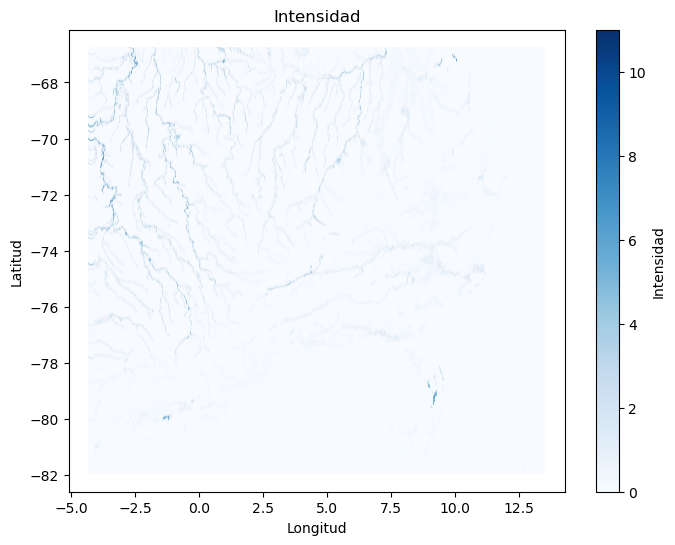

In [6]:
import numpy as np

haz = hazards_final["historical"]

# Convertir matriz dispersa a array denso
intensity_matrix = haz.intensity.toarray() if not isinstance(haz.intensity, np.ndarray) else haz.intensity

# Promedio de intensidades por centroid (columna)
mean_intensity = intensity_matrix.mean(axis=0)

# Coordenadas de centroides
lons = haz.centroids.coord[:, 0]
lats = haz.centroids.coord[:, 1]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(lons, lats, c=mean_intensity, cmap="Blues", s=10)
plt.colorbar(label="Intensidad")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.title("Intensidad")
plt.show()

In [16]:
import glob
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
from climada.entity import Exposures
from climada.engine import ImpactCalc


In [25]:
# =======================
# 1. Cargar población (WorldPop)
# =======================
path = "./Data/Pop"
files = sorted(glob.glob(f"{path}/*.tif"))

years = list(range(2015, 2031))  # 2015–2030

arrays = []
for file, year in zip(files, years):
    da = rxr.open_rasterio(file, masked=True).squeeze()  # elimina dim "band"
    da = da.assign_coords(time=pd.to_datetime(f"{year}-01-01"))  # agrega tiempo
    arrays.append(da)

da_pop = xr.concat(arrays, dim="time")
ds_pop = xr.Dataset({"population": da_pop})

print("✅ Dataset de población cargado:", ds_pop)

✅ Dataset de población cargado: <xarray.Dataset> Size: 275MB
Dimensions:      (x: 1787, y: 2403, time: 16)
Coordinates:
    band         int32 4B 1
  * x            (x) float64 14kB -81.74 -81.73 -81.72 ... -66.87 -66.86 -66.85
  * y            (y) float64 19kB 15.8 15.79 15.78 ... -4.204 -4.212 -4.221
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 128B 2015-01-01 2016-01-01 ... 2030-01-01
Data variables:
    population   (time, y, x) float32 275MB nan nan nan nan ... nan nan nan nan


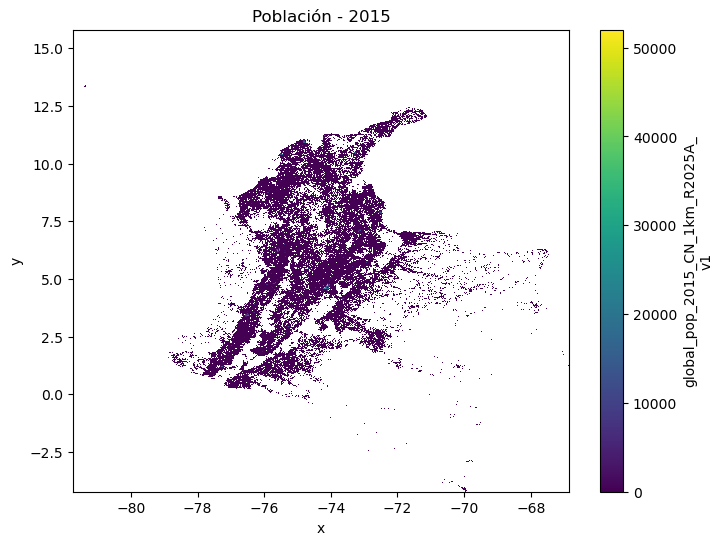

In [26]:
# Seleccionar un momento en el tiempo
pop_2015 = ds_pop.sel(time="2015-01-01")["population"]

# Graficar
pop_2015.plot(cmap="viridis", figsize=(8,6))
plt.title("Población - 2015")
plt.show()

In [8]:
def pop_to_exposures(da_pop, year):
    # Coordenadas
    lat = da_pop['y'].values
    lon = da_pop['x'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Valores de población
    pop_vals = da_pop.sel(time=str(year)).values

    df = pd.DataFrame({
    "latitude": lat_grid.flatten(),
    "longitude": lon_grid.flatten(),
    "value": pop_vals.flatten(),
    "impf_RF": 1   # 👈 CLIMADA espera esta columna porque haz_type='RF'
})
    df = df[df["value"] > 0]

    return Exposures(df)

In [20]:
from climada.entity import ImpactFunc, ImpactFuncSet

# Crear una función de impacto lineal muy simple
impf = ImpactFunc()

impf.haz_type = 'RF'        # mismo hazard_type que usaste al crear Hazard
impf.id = 1                 # ID de la función
impf.name = 'Flood mortality simple'

# Intensidades en metros (eje X) y vulnerabilidad [0–1] (eje Y)
impf.intensity = np.array([0, 0.5, 1.0, 2.0, 5.0])   # umbrales de agua
impf.mdd = np.array([0.0, 0.2, 0.5, 0.8, 1.0])       # mortalidad relativa (fractions)
impf.paa = np.ones_like(impf.intensity)              # prob. de afectar exposición (1 = siempre)

# Agrupar en un ImpactFuncSet
impf_set = ImpactFuncSet([impf])

In [21]:
#. Bucle de cálculo de impactos
# =======================
impact_results = {}

for scen, haz in hazards_final.items():
    scen_results = {}
    for year in range(2015, 2031):
        print(f"🔄 Procesando {scen}, año {year}...")

        # a) Crear exposiciones
        exp = pop_to_exposures(ds_pop["population"], year)

        # b) Calcular impacto
        imp_calc = ImpactCalc(exp, impf_set, haz)
        impact = imp_calc.impact()

        # c) Guardar resultado
        scen_results[year] = impact

    impact_results[scen] = scen_results


# =======================
# 4. Ejemplo de resultados
# =======================
for scen, res in impact_results.items():
    print(f"\n📊 Escenario: {scen}")
    for year, impact in res.items():
        # pérdidas totales (suma sobre eventos)
        print(year, impact.at_event.sum())

🔄 Procesando historical, año 2015...
🔄 Procesando historical, año 2016...
🔄 Procesando historical, año 2017...
🔄 Procesando historical, año 2018...
🔄 Procesando historical, año 2019...
🔄 Procesando historical, año 2020...
🔄 Procesando historical, año 2021...
🔄 Procesando historical, año 2022...
🔄 Procesando historical, año 2023...
🔄 Procesando historical, año 2024...
🔄 Procesando historical, año 2025...
🔄 Procesando historical, año 2026...
🔄 Procesando historical, año 2027...
🔄 Procesando historical, año 2028...
🔄 Procesando historical, año 2029...
🔄 Procesando historical, año 2030...
🔄 Procesando rcp4p5, año 2015...
🔄 Procesando rcp4p5, año 2016...
🔄 Procesando rcp4p5, año 2017...
🔄 Procesando rcp4p5, año 2018...
🔄 Procesando rcp4p5, año 2019...
🔄 Procesando rcp4p5, año 2020...
🔄 Procesando rcp4p5, año 2021...
🔄 Procesando rcp4p5, año 2022...
🔄 Procesando rcp4p5, año 2023...
🔄 Procesando rcp4p5, año 2024...
🔄 Procesando rcp4p5, año 2025...
🔄 Procesando rcp4p5, año 2026...
🔄 Procesando

In [22]:
for scen, res in impact_results.items():
    print(f"\n📊 Escenario: {scen}")
    for year, impact in res.items():
        print(year, int(impact.at_event.sum()))


📊 Escenario: historical
2015 9439465
2016 9521885
2017 9629421
2018 9803948
2019 9994079
2020 10165711
2021 10290505
2022 10395021
2023 10515359
2024 10633698
2025 10746766
2026 10853520
2027 10954376
2028 11051348
2029 11142927
2030 11229922

📊 Escenario: rcp4p5
2015 7504859
2016 7569908
2017 7654900
2018 7792608
2019 7941824
2020 8076724
2021 8175071
2022 8257523
2023 8352430
2024 8445797
2025 8534783
2026 8619025
2027 8698636
2028 8775121
2029 8847237
2030 8915873

📊 Escenario: rcp8p5
2015 6581981
2016 6638866
2017 6713272
2018 6833963
2019 6964546
2020 7082676
2021 7168785
2022 7240969
2023 7324007
2024 7405733
2025 7483580
2026 7557319
2027 7627024
2028 7693969
2029 7757097
2030 7817197


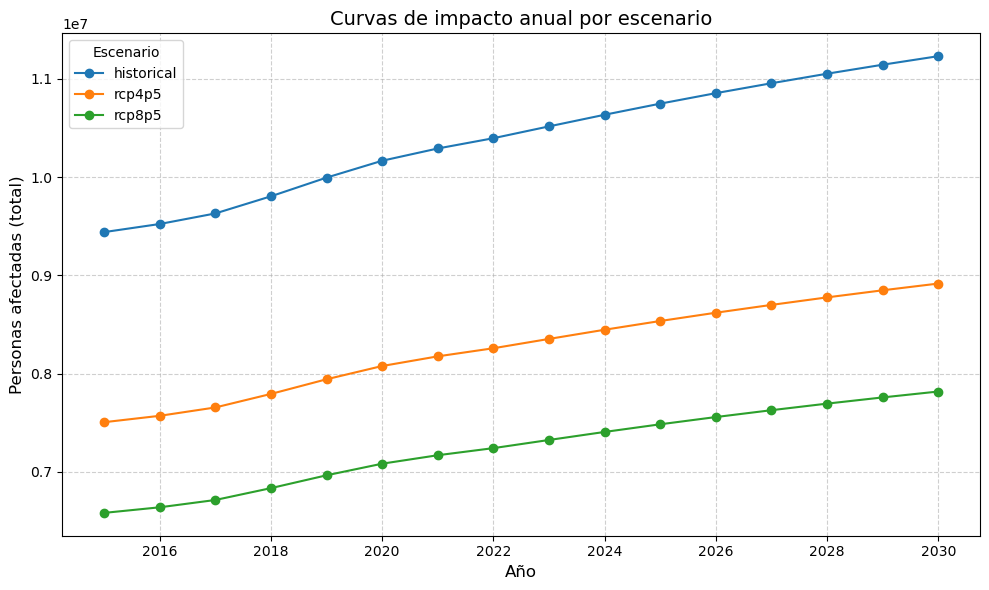

In [25]:
import matplotlib.pyplot as plt

# Crear figura
plt.figure(figsize=(10,6))

for scen, res in impact_results.items():
    years = list(res.keys())
    totals = [int(impact.at_event.sum()) for impact in res.values()]

    plt.plot(years, totals, marker="o", label=scen)

plt.xlabel("Año", fontsize=12)
plt.ylabel("Personas afectadas (total)", fontsize=12)
plt.title("Curvas de impacto anual por escenario", fontsize=14)
plt.legend(title="Escenario")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## CLIMADA FRAMEWORK DROUGHT

In [2]:
import os
import numpy as np
import xarray as xr
import rioxarray
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# -------------------------
# 1️⃣ Ajustes del usuario
# -------------------------
base_dir = "./Data/SPEI/NETCDF/"
output_dir = os.path.join("./Data/SPEI/", "hazards_tif")
os.makedirs(output_dir, exist_ok=True)

# Periodos (ajustables)
periods = {
    "historical": ("1975-01-01", "2005-12-31"),
    "midcentury": ("2030-01-01", "2060-12-31"),
    "endcentury": ("2070-01-01", "2100-12-31"),
}

# =============================
# 🔁 Procesamiento de cada archivo .nc
# =============================
for fname in os.listdir(base_dir):
    if fname.endswith(".nc"):
        nc_path = os.path.join(base_dir, fname)
        print(f"\n📘 Procesando archivo: {fname}")

        # 1️⃣ Abrir dataset
        ds = xr.open_dataset(nc_path)
        var_name = [v for v in ds.data_vars if "spei" in v.lower()][0]
        da = ds[var_name]

        # Asegurar CRS
        if not da.rio.crs:
            da = da.rio.write_crs("EPSG:4326")

        # 2️⃣ Procesar cada periodo
        for label, (start, end) in periods.items():
            subset = da.sel(time=slice(start, end))
            mean_spei = subset.mean(dim="time", skipna=True)

            # ⚙️ Reescribir CRS (por seguridad)
            mean_spei = mean_spei.rio.write_crs("EPSG:4326", inplace=True)

            # 3️⃣ Nombrar salida
            realization = fname.split("_")[-1].replace(".nc", "")  # r1i1p1, etc.
            out_name = f"SPEI_{label}_rcp85_{realization}.tif"
            out_path = os.path.join(output_dir, out_name)

            # 4️⃣ Exportar GeoTIFF
            mean_spei.rio.to_raster(out_path)
            print(f"✅ Guardado: {out_name}")

        ds.close()

print("\n🎯 Conversión completa: todos los TIFFs generados correctamente.")


📘 Procesando archivo: SPEI_12_Amon_EC-EARTH3-HR_rcp85_r1i1p1.nc
✅ Guardado: SPEI_historical_rcp85_r1i1p1.tif
✅ Guardado: SPEI_midcentury_rcp85_r1i1p1.tif
✅ Guardado: SPEI_endcentury_rcp85_r1i1p1.tif

📘 Procesando archivo: SPEI_12_Amon_EC-EARTH3-HR_rcp85_r2i1p1.nc
✅ Guardado: SPEI_historical_rcp85_r2i1p1.tif
✅ Guardado: SPEI_midcentury_rcp85_r2i1p1.tif
✅ Guardado: SPEI_endcentury_rcp85_r2i1p1.tif

📘 Procesando archivo: SPEI_12_Amon_EC-EARTH3-HR_rcp85_r3i1p1.nc
✅ Guardado: SPEI_historical_rcp85_r3i1p1.tif
✅ Guardado: SPEI_midcentury_rcp85_r3i1p1.tif
✅ Guardado: SPEI_endcentury_rcp85_r3i1p1.tif

📘 Procesando archivo: SPEI_12_Amon_EC-EARTH3-HR_rcp85_r5i1p1.nc
✅ Guardado: SPEI_historical_rcp85_r5i1p1.tif
✅ Guardado: SPEI_midcentury_rcp85_r5i1p1.tif
✅ Guardado: SPEI_endcentury_rcp85_r5i1p1.tif

📘 Procesando archivo: SPEI_12_Amon_EC-EARTH3-HR_rcp85_r6i1p1.nc
✅ Guardado: SPEI_historical_rcp85_r6i1p1.tif
✅ Guardado: SPEI_midcentury_rcp85_r6i1p1.tif
✅ Guardado: SPEI_endcentury_rcp85_r6i1p1.tif


In [5]:
import numpy as np
import rioxarray as rxr
from climada.hazard import Hazard, Centroids
from scipy.sparse import csr_matrix

def spei_nc_to_hazard(nc_path, start=None, end=None):
    """
    Genera un Hazard CLIMADA usando todos los tiempos reales del NetCDF.
    """
    ds = xr.open_dataset(nc_path)
    var = [v for v in ds.data_vars if "spei" in v.lower()][0]
    da = ds[var]

    # Subconjunto temporal si se pide
    if start and end:
        da = da.sel(time=slice(start, end))

    # Asegurar CRS
    if not da.rio.crs:
        da = da.rio.write_crs("EPSG:4326")

    times = da.time.values
    n_events = len(times)

    # Crear matriz eventos x pixeles
    arr = da.values.reshape(n_events, -1)

    # Coordenadas
    lat = da["lat"].values
    lon = da["lon"].values
    xx, yy = np.meshgrid(lon, lat)

    cent = Centroids(lat=yy.flatten(), lon=xx.flatten())

    haz = Hazard("DR")
    haz.centroids = cent
    haz.units = "SPEI"

    haz.intensity = arr
    haz.date = times
    haz.event_id = np.arange(1, n_events + 1)
    haz.frequency = np.ones(n_events) / n_events

    return haz

In [6]:
periods = {
    "historical": ("1975-01-01", "2005-12-31"),
    "midcentury": ("2030-01-01", "2060-12-31"),
    "endcentury": ("2070-01-01", "2100-12-31"),
}

hazards = {}

for fname in os.listdir(base_dir):
    if fname.endswith(".nc"):
        nc_path = os.path.join(base_dir, fname)

        for label, (start, end) in periods.items():
            haz = spei_nc_to_hazard(nc_path, start, end)
            hazards[f"{label}_{fname}"] = haz

print("Hazards generados:", len(hazards))

Hazards generados: 18


In [11]:
# ------------------------------
# CONFIGURACIÓN
# ------------------------------

period_list = ["historical", "midcentury", "endcentury"]

# coordenadas globales del modelo EC-EARTH3-HR (360x720)
lats = np.linspace(-89.75, 89.75, 360)
lons = np.linspace(-179.75, 179.75, 720)

# Extensión de Colombia
lat_min, lat_max = -5, 13
lon_min, lon_max = -82, -66

lat_idx = np.where((lats >= lat_min) & (lats <= lat_max))[0]
lon_idx = np.where((lons >= lon_min) & (lons <= lon_max))[0]

# almacenamiento temporal
arrs = {p: [] for p in period_list}

vmin_global = np.inf
vmax_global = -np.inf

# ------------------------------
# PROCESAR TODOS LOS HAZARDS
# ------------------------------

for key, haz in hazards.items():

    # identificar periodo según el nombre
    period = None
    for p in period_list:
        if key.startswith(p):
            period = p
            break
    if period is None:
        continue

    # intensidad: compatible con sparse o ndarray
    intensity = haz.intensity
    if hasattr(intensity, "toarray"):
        intensity = intensity.toarray()

    # asegurar vector plano → 360x720
    arr = intensity.reshape(360, 720)

    # recorte Colombia
    arr_col = arr[
        lat_idx.min():lat_idx.max()+1,
        lon_idx.min():lon_idx.max()+1
    ]

    arrs[period].append(arr_col)

    # actualizar rangos globales
    vmin_global = min(vmin_global, np.nanmin(arr_col))
    vmax_global = max(vmax_global, np.nanmax(arr_col))

# si el contraste es bajo
if abs(vmax_global - vmin_global) < 0.05:
    vmin_global, vmax_global = -2, 2


# ------------------------------
# GRAFICAR
# ------------------------------

fig, axes = plt.subplots(
    3, 1,
    figsize=(8, 12),
    constrained_layout=True
)

for i, p in enumerate(period_list):

    if len(arrs[p]) == 0:
        axes[i].text(0.5, 0.5, "Sin datos", ha='center')
        continue

    # promedio del periodo
    arr_mean = np.nanmean(arrs[p], axis=0)

    im = axes[i].imshow(
        arr_mean,
        cmap="RdBu_r",
        vmin=vmin_global, vmax=vmax_global,
        extent=[lon_min, lon_max, lat_min, lat_max],
        origin="lower"
    )

    axes[i].set_title(f"SPEI – {p}", fontsize=12)
    axes[i].grid(alpha=0.25, linestyle="--")

# colorbar única
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal", pad=0.1)
cbar.set_label("SPEI – Hazard intensity", fontsize=12)

plt.show()

ValueError: cannot reshape array of size 96422400 into shape (360,720)

In [12]:
def pop_to_exposures(da_pop, year):
    lat = da_pop['y'].values
    lon = da_pop['x'].values
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    pop_vals = da_pop.sel(time=str(year)).values

    df = pd.DataFrame({
        "latitude": lat_grid.flatten(),
        "longitude": lon_grid.flatten(),
        "value": pop_vals.flatten(),
        "impf_DR": 1     # 👈 CLIMADA usará la función de impacto de sequía
    })

    return Exposures(df[df["value"] > 0])

In [13]:
from climada.entity import ImpactFunc, ImpactFuncSet

impf = ImpactFunc()
impf.haz_type = 'DR'
impf.id = 1
impf.name = 'Drought vulnerability (SPEI-based)'

impf.intensity = np.array([0, -1, -1.5, -2, -3])
impf.mdd =       np.array([0.0, 0.1, 0.3, 0.7, 1.0])
impf.paa = np.ones_like(impf.intensity)

impf_set = ImpactFuncSet([impf])

In [17]:
# =======================
# 1. Cargar población (WorldPop)
# =======================
path = "./Data/Pop"
files = sorted(glob.glob(f"{path}/*.tif"))

years = list(range(2015, 2031))  # 2015–2030

arrays = []
for file, year in zip(files, years):
    da = rxr.open_rasterio(file, masked=True).squeeze()  # elimina dim "band"
    da = da.assign_coords(time=pd.to_datetime(f"{year}-01-01"))  # agrega tiempo
    arrays.append(da)

da_pop = xr.concat(arrays, dim="time")
ds_pop = xr.Dataset({"population": da_pop})

print("✅ Dataset de población cargado:", ds_pop)

✅ Dataset de población cargado: <xarray.Dataset> Size: 275MB
Dimensions:      (x: 1787, y: 2403, time: 16)
Coordinates:
    band         int32 4B 1
  * x            (x) float64 14kB -81.74 -81.73 -81.72 ... -66.87 -66.86 -66.85
  * y            (y) float64 19kB 15.8 15.79 15.78 ... -4.204 -4.212 -4.221
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 128B 2015-01-01 2016-01-01 ... 2030-01-01
Data variables:
    population   (time, y, x) float32 275MB nan nan nan nan ... nan nan nan nan


In [25]:
for scen in scenarios:
    impact_results[scen] = {}

    for year in years:
        fname = f"SPEI_{scen}_{year}.tif"
        haz_dr = hazards[fname]

        # aseguramos metadatos mínimos
        if haz_dr.date is None or len(haz_dr.date) == 0:
            haz_dr.date = np.array([np.datetime64(f"{year}-01-01")])

        if haz_dr.frequency is None or len(haz_dr.frequency) == 0:
            haz_dr.frequency = np.array([1])

        haz_dr.event_id = np.arange(1, haz_dr.intensity.shape[0] + 1)

        # exposición del año correspondiente
        exp = pop_to_exposures(da_pop, year)

        # calcular impacto
        imp = Impact()
        imp.calc(exp, impf_set, haz_dr)

        # guardar
        impact_results[scen][year] = imp

NameError: name 'scenarios' is not defined

In [22]:
# =============================
# VALIDACIÓN DE RESULTADOS
# =============================
for scen, res in impact.items():
    print(f"\n📌 Validando escenario: {scen}")
    
    for year, impact in res.items():
        if hasattr(impact, "at_event") and impact.at_event is not None:
            total = np.sum(impact.at_event)
            print(f"  Año {year}: OK – total impact = {total:.2f}")
        else:
            print(f"  ⚠️ Año {year}: impacto inválido o vacío")

AttributeError: 'Impact' object has no attribute 'items'

In [20]:
# Crear figura
plt.figure(figsize=(10,6))

for scen, res in impact_results.items():
    years = list(res.keys())
    totals = [int(impact.at_event.sum()) for impact in res.values()]

    plt.plot(years, totals, marker="o", label=scen)

plt.xlabel("Año", fontsize=12)
plt.ylabel("Personas afectadas (total)", fontsize=12)
plt.title("Curvas de impacto anual por escenario", fontsize=14)
plt.legend(title="Escenario")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

NameError: name 'impact_results' is not defined

<Figure size 1000x600 with 0 Axes>